In [1]:
import numpy as np
import pandas as pd 
from tqdm import tqdm
import numba 
from numba import njit,vectorize, jit
import time 
import scipy
import matplotlib.pyplot as plt
import numpy.linalg as LA

In [2]:
!pwd

/home/bastien/Documents/ENS/KM/Kernel_Methods/machine-learning-with-kernel-methods-2021


In [3]:
sig2 = 1
d = 2
c = 0

In [4]:
X_train = pd.read_csv('data/Xtr0_mat100.csv', header=None, delimiter = ' ').to_numpy()

In [5]:
@njit
def PolynomialKernel(x,y): 
    return (x.dot(y)+c)**d
@njit
def LinearKernel(x,y): 
    return x.dot(y)

In [6]:
@njit
def GaussianKernel(x,y,sig2 = 1): 
    return np.exp(-1/(2*sig2)*LA.norm(x-y)**2)

@njit
def to_mat_K(X, Kernel): 
    length = X.shape[0]
    mat_K = np.zeros((length,length))
    for i in range(length):
        x_i = X[i,:]
        for j in range(i,length): 
            x_j = X[j,:]
            value = Kernel(x_i,x_j)
            mat_K[i,j] = value
            mat_K[j,i] = value 
    return mat_K  



def standardize(K): 
    U = np.full(K.shape,1/K.shape[0])
    I = np.eye(K.shape[0])
    return (I-U)@K@(I-U)

def KPCA(mat_K,nb_components): 
    '''
    Compute the KernelPCA of the matrix mat_K. To project for visiualisation, we will need to renormalize the matrix mat_K before multiplying with the output.
    
    args : 
        mat_K : Kernel Matrix of size (nb_samples, nb_samples)
        
        nb_components: the number of vectors we want in the kernel PCA. Typically, for vizualization, we will take nb_components = 2 
        
    returns : the nb_components firsts bigger eigenvectors of the Kernel matrix, that is the nb_component more meaningful directions. 
    
    '''
    # first standardize the matrix
    mat_K = standardize(np.copy(mat_K))
    
    #we extract the eigenvectors and eigenvalues
    W,V = LA.eigh(mat_K)
    return V[:,-nb_components:]/np.sqrt(W[-nb_components:])

In [7]:
def PCA(X,nb_components): 
    '''
    Compute the PCA of X
    
    args : 
        X: training sample of size (nb_samples, dimension of each sample)
        
        nb_components: the number of vectors we want in the PCA. Typically, for vizualization, we will take nb_components = 2 
        
    returns : the nb_components firsts bigger eigenvectors of the covariance matrix, that is the nb_component more meaningful directions. 
    '''
    
    # centering 
    X_centered = np.copy(X-np.mean(X,axis = 0))
    
    #compute the Gram Matrix
    cov = X_centered.T@X_centered
    
    #compute the eigenvalues and eigen vectors
    values, vectors = np.linalg.eigh(cov)
    return vectors[:,-nb_components]

In [8]:
def create_z(mu_init, nb_samples): 
    '''
    small function to create  GMM. The only purpose of it is to test our KernelKmeans and Kmeans
    '''
    
    K = len(mu_init)
    z = mu_init[0]+ np.random.randn(nb_samples,2)
    true_clusters = np.zeros(nb_samples)
    for i in range(1,K): 
        z = np.concatenate((mu_init[i]+ np.random.randn(nb_samples,2),z),axis = 0)
        true_clusters = np.concatenate((true_clusters,np.full(nb_samples,i)))

    return z,true_clusters 

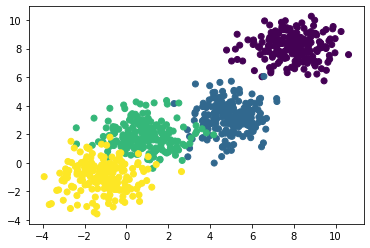

In [9]:
nb_samples = 200
mu_init_z = np.array([[-1,-1],[1,2],[5,3],[8,8]])
nb_clusters = len(mu_init_z)
z,true_clusters = create_z(mu_init_z,nb_samples)
plt.scatter(z[:,0],z[:,1], c = true_clusters)

In [10]:
def cluster_assignment(mu,z,K): 
    '''
    Update the clusters for the Kmeans algorithm 
    
    args : 
            mu : vectors that contains each estimated mean for each cluster(i.e. the estimated centroid) (size (nb_clusters,dimension of each sample))
            
            z : the vectors we train on. size (nb_samples, dimension of each sample)
            
            K : the number of clusters we want. 
            
    returns : 
            
            clusters : the estimated clusters, size (nb_samples,). One coord i is the numero of the cluster we give to sample i.  
    '''
    #initialization
    clusters = np.zeros(z.shape[0])
    
    # we loop on each sample
    for i in range(z.shape[0]): 
        # compute the distance at each centroid
        distance = np.array([LA.norm(z[i]-centroid) for centroid in mu])
        
        # We associate the point with its closest centroid
        clusters[i]=  np.argmin(distance)
    return clusters    
    
def centroids_update(z, clusters,K): 
    
    '''
    Update the centroids given the clusters. 
    
    args : 
            z : the vectors we train on. size (nb_samples, dimension of each sample)
            
            clusters : the estimated clusters we have. Given this, we are ready to update the centroids. size : (nb_samples,)
            
            K : the number of clusters we want. 
    
    returns : 
            mu_chap : vector of size(nb_clusters,nb_dimension for each sample). It contains each estimation of the centroids. 
            Note that mu_chap is completely equivalent to centroids
    '''
    #Initialization
    mu_chap = np.zeros((K,z.shape[1]))
    
    #we loop on each clusters
    for j in range(K):
        
        # a mask to compute each centroid. More information on the slides 183
        mask = (clusters ==j).reshape(-1,1)
        if np.sum(mask)!=0:
            mu_chap[j] = np.sum(np.multiply(z,mask),axis = 0)/np.sum(mask)
    return mu_chap 
            
            

class KMeans(): 
    
    '''
    class Kmeans to simplify the training. It regroups all the functions above. 
    '''
    def __init__(self): 
        pass
    def fit(self,z, K ,Niter_max=6, viz = True): 
        
        '''
        fit function for Kmeans. Compute K clusters with the Kmeans algorithm. 
        
        
        args : 
                z : the vector we train on (the data). size : (nb_samples, nb dimension of each sample)
                
                K : the number of clusters we want. This is the only hyperparameter to tune.
                The only that will really change the result of the algorithm
                
                Niter_max : the number of iteration we want the algorithm to do. 
                
                viz : Booleen that tells if we want to visualize each update. 
                
        returns : None. However, we can access the clusters and the centroids if we do self.clusters or self.mu_chap
        '''
        self.K = K 
        self.z = z
        mu_chap = 3*np.random.randn(K,2)
        clusters = cluster_assignment(mu_chap, self.z,self.K)
        for i in range(Niter_max): 
            #Update of the clusters 
            clusters = cluster_assignment(mu_chap, self.z,self.K)
            
            #update of the centroids. mu_chap is equivalent to centroids 
            mu_chap = centroids_update(self.z,clusters,self.K)
            if viz : 
                plt.scatter(z[:,0],z[:,1], c = clusters)
                plt.title('Update :clusters recognized')
                plt.show()
        if viz : 
            plt.scatter(z[:,0],z[:,1], c = true_clusters)
            plt.title('True Clusters')
            plt.show()
        self.mu_chap = mu_chap
        self.clusters = clusters
        



In [11]:
def compute_one_loss(mat_K, clusters,K,i):
    '''
    compute the loss we want to minimize for the sample i. The loss is given in slides 186. 
    
    args : 
        mat_K : Kernel Matrix of size (nb_samples, nb_samples)
        
        clusters : the clusters we have estimated for each sample. size : (nb_samples,). Each coord i is the numero 
        of the clusters we think sample i is in.  
        
        K : the number of clusters we want. int variable. 
        
        i : the numero of the sample. int variable.
    
    returns : 
        loss : numpy array of size (nb_clusters,). Each coordinate i is the loss of the cluster i  
    '''
    
    loss = np.zeros(K)
    
    # we loop on each cluster. 
    for s in range(K):
        # a mask to compute the loss. Check slide 186 for more intuition on this. 
        mask_vector = (clusters == s).astype(np.float64)
        
        # we initialize the two first terms. (here, we did not take into account K(x_i,x_i) since we only
        # want the argmin. So in slide 186 it correspond to second and third term)
        first_term = 0 
        second_term = 0 
        C_s = np.sum(mask_vector)
        if C_s != 0 :
            # we compute the first term 
            first_term = -2/C_s*np.sum(mat_K[i,:]*mask_vector)
            
            # a mask on the matrix
            mask_matrix = mask_vector.reshape(-1,1)@mask_vector.reshape(1,-1)
            
            #we compute the second term. 
            second_term = 1/(C_s)**2*np.sum(mat_K*mask_matrix)
        loss[s] = first_term + second_term
    return loss
#@njit


def kernel_cluster_assignment(mat_K,clusters,K):# we actually don't need mu here
    '''
    Update the clusters. Note that here, the centroids are update on the fly. 
    
    args : 
        mat_K : Kernel Matrix of size (nb_samples, nb_samples)
        
        clusters : the clusters we have estimated for each sample. size : (nb_samples,). Each coord i is the numero 
        of the clusters we think sample i is in.  
        https://fr.wikipedia.org/wiki/Noyau_polynomial
        K : the number of clusters we want. int variable. 
    
    return : 
            new_clusters : the clusters update with the formula ont the slides 183
    '''
    #Initilialization
    new_clusters = np.empty(clusters.shape)
    #we loop over the clusters 
    for i in range(mat_K.shape[0]):
        new_clusters[i] = np.argmin(compute_one_loss(mat_K,clusters,K,i)) # we compute the loss and then just take the argmin 
    return new_clusters
  
class KernelKmeans(): 
    '''
    Class that computes the Kernel Kmeans algorithm. 
    '''
    
    def __init__(self): 
        pass 
    def fit(self, mat_K, K,z= None, Niter_max = 10, viz = True): 
        '''
        computes the Kernel Kmeans given the Kernel Matrix mat_K. 
        
        args : 
            mat_K : Kernel Matrix of size (nb_samples, nb_samples)
            
            z : original data that was used to compute the Kernel_Matrix. It is used only for visualization. 
            
            K : the number of clusters we want. int variable. 
            
            viz : booleen that is used for visualization. If viz == True, then z must not be one. 
            The visualization is done by PCA 
            
        returns : None but we can get the clusters found with self.clusters
            
            
        
        '''
        if (np.array((z==None)).any()) and viz == True : 
            print('Please give the data vector so we can visualize it. ')
            return None 
        self.K = K
        self.mat_K = mat_K 
        self.best_coords = KPCA(self.mat_K, nb_components = 2) 
        self.clusters = np.random.randint(0,high = K, size = self.mat_K.shape[0])
        if viz : 
            print('Initilisation : ')
            self.best_coords = z # uncomment this if you want to visualize the vector without PCA 
            plt.scatter(self.best_coords[:,0],self.best_coords[:,1], c = self.clusters)
            plt.show()
        for i in range(Niter_max): 
            self.clusters = kernel_cluster_assignment(self.mat_K,self.clusters,self.K)
            if viz : 
                print('Update : ')
                plt.scatter(self.best_coords[:,0],self.best_coords[:,1], c = self.clusters)
                plt.show()       

In [12]:
mat_gaussian = to_mat_K(z,GaussianKernel)
mat_linear = to_mat_K(z,LinearKernel)
mat_poly = to_mat_K(z,PolynomialKernel)

In [13]:
unsupervised = KernelKmeans()
#%time unsupervised.fit(mat_poly,4,z=z)

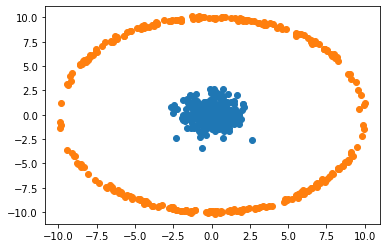

In [14]:
r=100
nb_points = 300
center = np.random.randn(nb_points,2)
outside_x = (2*np.random.randint(2,size= nb_points)-1)*np.sqrt(r)*np.random.rand(nb_points)
outside_y = (2*np.random.randint(2,size= nb_points)-1)*np.sqrt(r-outside_x**2)
outside_x += 0.1*np.random.randn(nb_points)
outside_y += 0.1*np.random.randn(nb_points)
plt.scatter(center[:,0],center[:,1])
plt.scatter(outside_x,outside_y)

In [15]:
outside = np.column_stack((outside_x,outside_y))
z_rond = np.concatenate((center,outside))

In [21]:

mat_gaussian_z_rond = to_mat_K(z_rond,GaussianKernel)

Initilisation : 


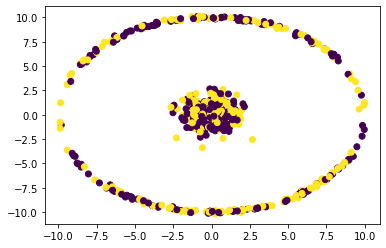

Update : 


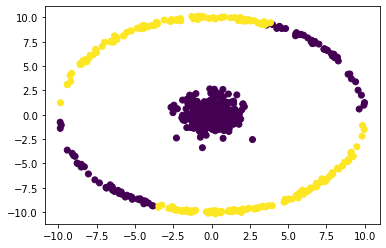

Update : 


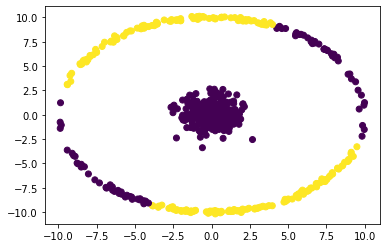

Update : 


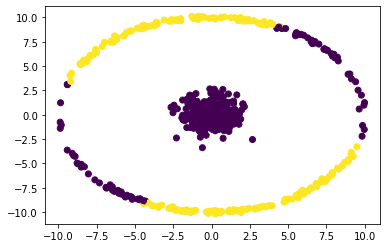

In [30]:
d = 1.2
c = -1
sig2 =0.1
mat_poly_z_rond = to_mat_K(z_rond,PolynomialKernel)
unsupervised.fit(mat_poly_z_rond,2,Niter_max=3, z=z_rond,viz = True)

In [ ]:
unsupervised.fit(mat_poly_)